In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

### Data Loading & Preprocessing

Missing values per column:
 target                     0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

--- Exploratory Data Analysis ---


C:\Users\cjrso\AppData\Local\Temp\ipykernel_26436\1626841604.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=df, palette='viridis')


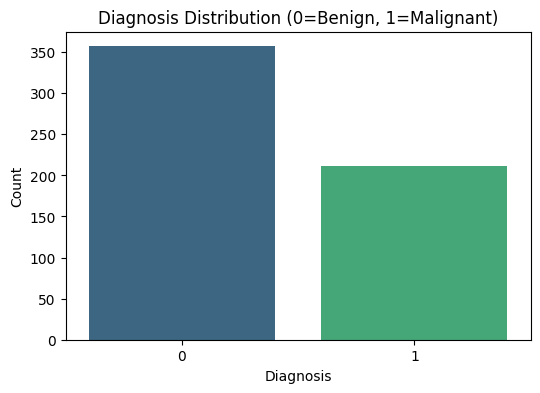

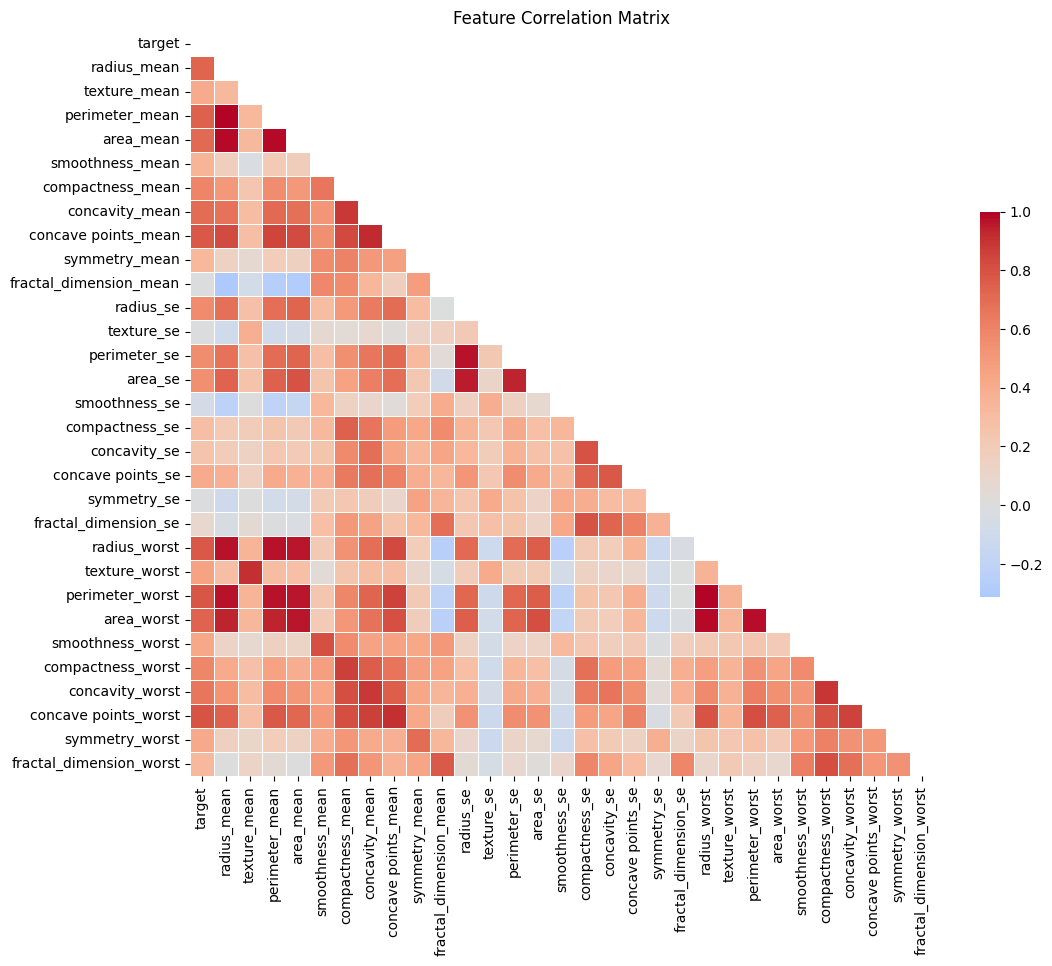

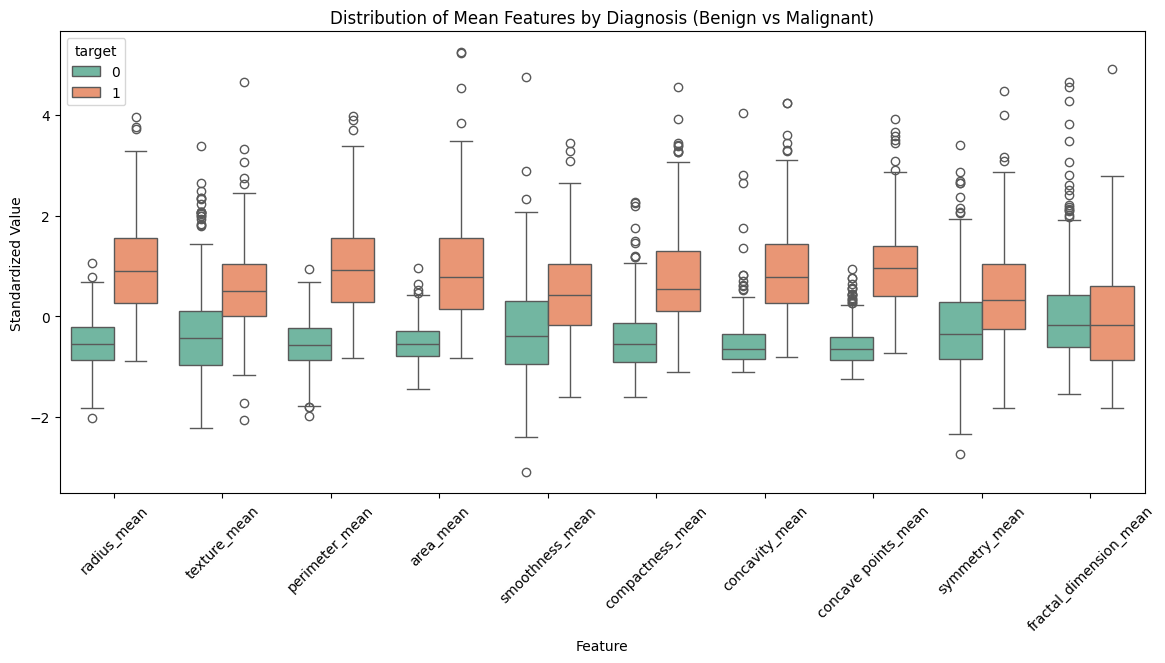

Train: (398, 30)
Validation: (114, 30)
Test: (57, 30)


In [2]:
def load_and_preprocess_data():
    """Load and preprocess the breast cancer data"""
    # Load data
    df = pd.read_csv("data.csv") #From kaggle - breast-cancer-wisconsin-datasets
    
    # Drop unnecessary columns
    df = df.drop(columns=["id", "Unnamed: 32"], errors='ignore')
    
    # Convert diagnosis
    df["diagnosis"] = df["diagnosis"].map({"M": 1, "B": 0})
    df.rename(columns={"diagnosis": "target"}, inplace=True)
    
    return df

def perform_eda(df):
    """Perform exploratory data analysis"""
    print("\n--- Exploratory Data Analysis ---")
    
    # 1. Target Distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(x='target', data=df, palette='viridis')
    plt.title('Diagnosis Distribution (0=Benign, 1=Malignant)')
    plt.xlabel('Diagnosis')
    plt.ylabel('Count')
    plt.show()
    
    # 2. Correlation Heatmap
    plt.figure(figsize=(12, 10))
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title('Feature Correlation Matrix')
    plt.show()

     # 3. Boxplot Analysis
    mean_cols = [col for col in df.columns if 'mean' in col]
    data_viz = df[mean_cols].copy()
    data_viz = (data_viz - data_viz.mean()) / data_viz.std()
    data_viz = pd.concat([df['target'], data_viz], axis=1)
    data_viz = pd.melt(data_viz, id_vars="target",
                       var_name="Feature",
                       value_name="Standardized Value")
    
    plt.figure(figsize=(14, 6))
    sns.boxplot(x="Feature", y="Standardized Value", hue="target", 
                data=data_viz, palette='Set2')
    plt.xticks(rotation=45)
    plt.title('Distribution of Mean Features by Diagnosis (Benign vs Malignant)')
    plt.show()

def prepare_data(df):
    """Split and scale the data"""
    X = df.drop("target", axis=1)
    y = df["target"]
    
    # Split train val test
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.30, random_state=42, stratify=y
    )
    
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.33, random_state=42, stratify=y_temp
    )
    
    print("Train:", X_train.shape)
    print("Validation:", X_val.shape)
    print("Test:", X_test.shape)

     # Scale
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    return X_train, X_val, X_test, y_train, y_val, y_test, scaler

# Start with fresh data
df = load_and_preprocess_data()

# Check for missing values
print("Missing values per column:\n", df.isnull().sum())

# Perform EDA
perform_eda(df)

# Prepare data for modeling
X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_data(df)

### ANN Model

In [3]:
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


d:\Assignment 2\venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 673 (2.63 KB)

 Trainable params: 673 (2.63 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
#Model Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=16,
    verbose=1
)

Epoch 1/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5101 - loss: 0.6802 - val_accuracy: 0.6842 - val_loss: 0.6575
Epoch 2/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8266 - loss: 0.6301 - val_accuracy: 0.8947 - val_loss: 0.6097
Epoch 3/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9095 - loss: 0.5642 - val_accuracy: 0.9386 - val_loss: 0.5328
Epoch 4/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9347 - loss: 0.4602 - val_accuracy: 0.9561 - val_loss: 0.4222
Epoch 5/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9422 - loss: 0.3439 - val_accuracy: 0.9561 - val_loss: 0.3077
Epoch 6/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9472 - loss: 0.2489 - val_accuracy: 0.9474 - val_loss: 0.2232
Epoch 7/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9523 - loss: 0.1877 - val_accuracy: 0.9561 - val_loss: 0.1733
Epoch 8/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9598 - loss: 0.1512 - val_accuracy: 0.9561 - val_loss